## Define Embedding Type

Our Bi-GRU architecture utilizes one of the following three embeddings:
1. CRAFT
   - This is our supervised embedding whose weights (or embedding values) are learnt during the model training on our inputs.
   - CRAFT has 100 dimensional output representation.
   
2. GLOVE
   - This is a 300 dimensional vector representations for words obtained from training on cased common crawled corpus with 840B tokens and 2.2M vocabulary.
   
3. ELMO
   - This is a 1024 dimensional vector representations for words obtained from training on 1B Word Benchmark, which consists of approximately 800M tokens of news crawl data.

In [1]:
EMBEDDING = "ELMO"
EXPERIMENT_NO = "1" # Useful only when conducting multiple experiments
assert EMBEDDING in ["CRAFT", "GLOVE", "ELMO"]

## Import Modules

In [2]:
import json
import os
from os.path import dirname, abspath, join
from itertools import chain

import numpy as np
import pandas as pd

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [3]:
if EMBEDDING == "ELMO":
#     Elmo does not support tf2
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
    from tensorflow.keras import backend as K

    from tensorflow.compat.v1.keras.backend import set_session
    import tensorflow_hub as hub
else:
    import tensorflow as tf
print("TensorFlow Version:", tf.version.VERSION)
print("GPU not available" if not tf.test.gpu_device_name() else "GPU available: {0}".format(tf.test.gpu_device_name()))
from tensorflow.keras.layers import GRU, Dense, Dropout, InputLayer, Embedding, Bidirectional, TimeDistributed, Input, Concatenate, SpatialDropout1D, Reshape, Lambda
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy

Instructions for updating:
non-resource variables are not supported in the long term
TensorFlow Version: 2.7.0
GPU available: /device:GPU:0


In [4]:
BASE_DIR = dirname(dirname(dirname(abspath("__file__"))))
DATA_DIR = join(BASE_DIR, "data")
MODEL_OUTPUT_DIR = join(DATA_DIR, "model_output")
GLOVE_EMB_FILE = join(DATA_DIR, "Embedding", "glove.840B.300d.bin")
DATASET_DIR = join(DATA_DIR, "model_input", "dataset")
SUBSUMER_FILE = join(DATA_DIR, "GO_Category", "GO_AllSubsumers.tsv")

## Load subsumer files

In [5]:
subsumers = dict()
infile = open(SUBSUMER_FILE)
for line in infile:
    child, subsumer = line.strip().split("\t")
    if child not in subsumers:
        subsumers[child] = set()
        subsumers[child].add(child)
    if subsumer != "owl:Thing":
        subsumers[child].add(subsumer)

## Define functions to calculate Semantic Similarity

To quantify partially accurate predictions, we use semantic similarity metrics. Here, Jaccard similarity is used that measures the ontological distance between two concepts. Two identical terms get semantic similarity score of 1.0. A higher semantic similarity indicates that there are instances where the model misses the exact prediction and yet predicts a partially related concept. A similarity score of 0.0 means that the two concepts are not related at all.

In [22]:
def simj(term1,term2,ancestors):
    if term1 not in ancestors:
        ancestors[term1]=set(term1)
    if term2 not in ancestors:
        ancestors[term2]=set(term2)
    if len(set.union(ancestors[term1],ancestors[term2])) >0:
        simj=len(set.intersection(ancestors[term1],ancestors[term2]))/len(set.union(ancestors[term1],ancestors[term2]))
    else:
        simj=0
    return simj

def getsimj(term1, term2):
    if term1 == term2:
        return 0 if term1 == "O" else 1
    else:
        return simj(term1, term2, subsumers)

## Configure parameters and hyperparameters

In [23]:
RUN = "{0}_{1}".format(EMBEDDING, globals().get("EXPERIMENT_NO", 1))
CONFIG = {
    "RUN": RUN, "OPTIMIZER": "Adam", "MODEL_NAME": "Bi-GRU_{0}".format(EMBEDDING),
    "BATCH_SIZE": 16, "MIN_SENT_LEN": 3, "MAX_WORD_LEN": 71, "MAX_CHAR_LEN": 15,"EPOCHS": 300,
    "LEARNING_RATE": 3e-4, "PAD_CHAR": "@", "EARLY_STOPPING": True, "RECURRENT_DROPOUT": 0,
    "DROPOUT": 0.1, "EMBEDDING": EMBEDDING, "ONE_HOT_ENCODING": True, "OPTIMIZED_CLASS_WEIGHT": True,
    "REDUCE_LR_ON_PLATEAU": True, "PROJECT_NAME": "NEMO", "OUTPUT_PARTS": 5
    # If kernel dies due to memory issues like low memory, increase the 'OUTPUT_PARTS' value.
    # Higher value means the model prediction is done recussively with smaller test_data. The computation
    # is done in parts (and finally combined) to get the final result.
}
CONFIG.update({
    "INPUT_LAYERS": {
        'tokens': True,
        'characters': True,
        'encodings': True,
        'iob_tags': True,
        'pos_tags': True,
        'protein_terms': True,
        'biomedical_terms': True,
        'chemical_terms': True,
        'macromolecule_terms': True,        
        'umls_terms': True
        }})
CONFIG.update(CONFIG.get("INPUT_LAYERS"))
EMBEDDING_DIM = 1024 if EMBEDDING=="ELMO" else 300 if EMBEDDING=="GLOVE" else 100
if EMBEDDING == "ELMO": CONFIG.update({"OPTIMIZED_CLASS_WEIGHT": False})
OPTIMIZER = Adam(learning_rate=CONFIG.get("LEARNING_RATE"))

## Load train and test data

In [9]:
train_data = json.load(open(join(DATASET_DIR, "train.json"), "r"))
test_data = json.load(open(join(DATASET_DIR, "test.json"), "r"))

# Remove inputs that have fewer tokens than 'MIN_SENT_LEN'
train_data = [i for i in train_data if len(i['tokens']) >= CONFIG['MIN_SENT_LEN']]
test_data = [i for i in test_data if len(i['tokens']) >= CONFIG['MIN_SENT_LEN']]

# Keep train and test data to be exactly divisible by 'BATCH_SIZE'
train_data = train_data[:len(train_data)//CONFIG.get("BATCH_SIZE")*CONFIG.get("BATCH_SIZE")]
test_data = test_data[:len(test_data)//CONFIG.get("BATCH_SIZE")*CONFIG.get("BATCH_SIZE")]

## Create dictionary to map strings to integer values

In [10]:
################################## TOKENS ######################################
if CONFIG.get("tokens"):
    all_words = [j for i in train_data + test_data for j in i['tokens']]
    unique_words = sorted(list(set(all_words)))

    word2idx = {**{CONFIG.get("PAD_CHAR"): 0}, **{w: i for i, w in enumerate(unique_words, 1)}}
    idx2word = {i: w for w, i in word2idx.items()}
    n_words = len(unique_words) + 1

################################ CHARACTERS ####################################
if CONFIG.get("characters"):
    all_chars = [j for i in all_words for j in i]
    unique_chars = sorted(list(set(all_chars)))

    char2idx = {**{CONFIG.get("PAD_CHAR"): 0}, **{c: i for i, c in enumerate(unique_chars, 1)}}
    n_chars = len(unique_chars) + 1

################################# ENCODINGS ####################################
if CONFIG.get("encodings"):
    all_char_encs = [j for i in train_data + test_data for j in i['encodings']]
    unique_char_encs = sorted(list(set(all_char_encs)))

    charenc2idx = {**{CONFIG.get("PAD_CHAR"): 0}, **{c: i for i, c in enumerate(unique_char_encs, 1)}}
    n_char_encs = len(unique_char_encs) + 1

################################# POS TAGS #####################################
if CONFIG.get("pos_tags"):
    all_pos = [j for i in train_data + test_data for j in i['pos_tags']]
    unique_pos = sorted(list(set(all_pos)))

    pos2idx = {**{CONFIG.get("PAD_CHAR"): 0}, **{p: i for i, p in enumerate(unique_pos, 1)}}
    n_pos = len(unique_pos) + 1

################################# IOB TAGS #####################################
if CONFIG.get("iob_tags"):
    all_tags = [j for i in train_data + test_data for j in i['iob_tags']]
    unique_tags = sorted(list(set(all_tags)))

    tag2idx = {**{CONFIG.get("PAD_CHAR"): 0}, **{t: i for i, t in enumerate(unique_tags, 1)}}
    idx2tag = {i: t for t, i in tag2idx.items()}
    n_tags = len(unique_tags) + 1

## Create input data for Bi-GRU model

In [11]:
X_train, X_test = [], []

# ------------------------------------------------------------------------------
if CONFIG.get("tokens"):
    if CONFIG.get("EMBEDDING") == "ELMO":
        token_train = [(i['tokens'], len(i['tokens'])) for i in train_data]
        X_token_train = [i[0][:CONFIG.get("MAX_WORD_LEN")] + [""]*(CONFIG.get("MAX_WORD_LEN")-i[1]) for i in token_train]
        X_train.append(np.array(X_token_train))

        token_test = [(i['tokens'], len(i['tokens'])) for i in test_data]
        X_token_test = [i[0][:CONFIG.get("MAX_WORD_LEN")] + [""]*(CONFIG.get("MAX_WORD_LEN")-i[1]) for i in token_test]
        X_test.append(np.array(X_token_test))
    else:
        X_token_train = [list(map(word2idx.get, i['tokens'])) for i in train_data]
        X_token_train = pad_sequences(maxlen=CONFIG.get("MAX_WORD_LEN"), sequences=X_token_train, padding='post', value=word2idx[CONFIG.get("PAD_CHAR")], truncating='post')
        X_train.append(X_token_train)

        X_token_test = [list(map(word2idx.get, i['tokens'])) for i in test_data]
        X_token_test = pad_sequences(maxlen=CONFIG.get("MAX_WORD_LEN"), sequences=X_token_test, padding='post', value=word2idx[CONFIG.get("PAD_CHAR")], truncating='post')
        X_test.append(X_token_test)

# ------------------------------------------------------------------------------
if CONFIG.get("characters"):
    X_char_train = [[list(map(char2idx.get, (j[:CONFIG.get("MAX_CHAR_LEN")] + CONFIG.get("PAD_CHAR") * (CONFIG.get("MAX_CHAR_LEN") - len(j))))) for j in (i['tokens'] + [CONFIG.get("PAD_CHAR")*CONFIG.get("MAX_CHAR_LEN")]*(CONFIG.get("MAX_WORD_LEN") - len(i['tokens'])))] for i in train_data]
    X_char_train = pad_sequences(maxlen=CONFIG.get("MAX_WORD_LEN"), sequences=X_char_train, padding='post', value=[char2idx[CONFIG.get("PAD_CHAR")]]*CONFIG.get("MAX_CHAR_LEN"), truncating='post')
    X_train.append(X_char_train)

    X_char_test = [[list(map(char2idx.get, (j[:CONFIG.get("MAX_CHAR_LEN")] + CONFIG.get("PAD_CHAR") * (CONFIG.get("MAX_CHAR_LEN") - len(j))))) for j in (i['tokens'] + [CONFIG.get("PAD_CHAR")*CONFIG.get("MAX_CHAR_LEN")]*(CONFIG.get("MAX_WORD_LEN") - len(i['tokens'])))] for i in test_data]
    X_char_test = pad_sequences(maxlen=CONFIG.get("MAX_WORD_LEN"), sequences=X_char_test, padding='post', value=[char2idx[CONFIG.get("PAD_CHAR")]]*CONFIG.get("MAX_CHAR_LEN"), truncating='post')
    X_test.append(X_char_test)

# ------------------------------------------------------------------------------
if CONFIG.get("encodings"):
    X_char_enc_train = [list(map(charenc2idx.get, i['encodings'])) for i in train_data]
    X_char_enc_train = pad_sequences(maxlen=CONFIG.get("MAX_WORD_LEN"), sequences=X_char_enc_train, padding='post', value=charenc2idx[CONFIG.get("PAD_CHAR")], truncating='post')
    # X_char_enc_train = np.expand_dims(X_char_enc_train, axis=-1)
    X_train.append(X_char_enc_train)

    X_char_enc_test = [list(map(charenc2idx.get, i['encodings'])) for i in test_data]
    X_char_enc_test = pad_sequences(maxlen=CONFIG.get("MAX_WORD_LEN"), sequences=X_char_enc_test, padding='post', value=charenc2idx[CONFIG.get("PAD_CHAR")], truncating='post')
    # X_char_enc_test = np.expand_dims(X_char_enc_test, axis=-1)
    X_test.append(X_char_enc_test)

# ------------------------------------------------------------------------------
if CONFIG.get("pos_tags"):
    X_pos_train = [list(map(pos2idx.get, i['pos_tags'])) for i in train_data]
    X_pos_train = pad_sequences(maxlen=CONFIG.get("MAX_WORD_LEN"), sequences=X_pos_train, padding='post', value=pos2idx[CONFIG.get("PAD_CHAR")], truncating='post')
    # X_pos_train = np.expand_dims(X_pos_train, axis=-1)
    X_train.append(X_pos_train)

    X_pos_test = [list(map(pos2idx.get, i['pos_tags'])) for i in test_data]
    X_pos_test = pad_sequences(maxlen=CONFIG.get("MAX_WORD_LEN"), sequences=X_pos_test, padding='post', value=pos2idx[CONFIG.get("PAD_CHAR")], truncating='post')
    # X_pos_test = np.expand_dims(X_pos_test, axis=-1)
    X_test.append(X_pos_test)
# ------------------------------------------------------------------------------
if CONFIG.get("protein_terms"):
    X_protein_train = [i['protein_terms'] for i in train_data]
    X_protein_train = pad_sequences(maxlen=CONFIG.get("MAX_WORD_LEN"), sequences=X_protein_train, padding='post', value=0, truncating='post')
    X_protein_train = np.expand_dims(X_protein_train, axis=-1)
    X_train.append(X_protein_train)

    X_protein_test = [i['protein_terms'] for i in test_data]
    X_protein_test = pad_sequences(maxlen=CONFIG.get("MAX_WORD_LEN"), sequences=X_protein_test, padding='post', value=0, truncating='post')
    X_protein_test = np.expand_dims(X_protein_test, axis=-1)
    X_test.append(X_protein_test)
# ------------------------------------------------------------------------------
if CONFIG.get("biomedical_terms"):
    X_bio_train = [i['biomedical_terms'] for i in train_data]
    X_bio_train = pad_sequences(maxlen=CONFIG.get("MAX_WORD_LEN"), sequences=X_bio_train, padding='post', value=0, truncating='post')
    X_bio_train = np.expand_dims(X_bio_train, axis=-1)
    X_train.append(X_bio_train)

    X_bio_test = [i['biomedical_terms'] for i in test_data]
    X_bio_test = pad_sequences(maxlen=CONFIG.get("MAX_WORD_LEN"), sequences=X_bio_test, padding='post', value=0, truncating='post')
    X_bio_test = np.expand_dims(X_bio_test, axis=-1)
    X_test.append(X_bio_test)
# ------------------------------------------------------------------------------
if CONFIG.get("chemical_terms"):
    X_chem_train = [i['chemical_terms'] for i in train_data]
    X_chem_train = pad_sequences(maxlen=CONFIG.get("MAX_WORD_LEN"), sequences=X_chem_train, padding='post', value=0, truncating='post')
    X_chem_train = np.expand_dims(X_chem_train, axis=-1)
    X_train.append(X_chem_train)

    X_chem_test = [i['chemical_terms'] for i in test_data]
    X_chem_test = pad_sequences(maxlen=CONFIG.get("MAX_WORD_LEN"), sequences=X_chem_test, padding='post', value=0, truncating='post')
    X_chem_test = np.expand_dims(X_chem_test, axis=-1)
    X_test.append(X_chem_test)
# ------------------------------------------------------------------------------
if CONFIG.get("macromolecule_terms"):
    X_macro_train = [i['macromolecule_terms'] for i in train_data]
    X_macro_train = pad_sequences(maxlen=CONFIG.get("MAX_WORD_LEN"), sequences=X_macro_train, padding='post', value=0, truncating='post')
    X_macro_train = np.expand_dims(X_macro_train, axis=-1)
    X_train.append(X_macro_train)

    X_macro_test = [i['macromolecule_terms'] for i in test_data]
    X_macro_test = pad_sequences(maxlen=CONFIG.get("MAX_WORD_LEN"), sequences=X_macro_test, padding='post', value=0, truncating='post')
    X_macro_test = np.expand_dims(X_macro_test, axis=-1)
    X_test.append(X_macro_test)
# ------------------------------------------------------------------------------
if CONFIG.get("umls_terms"):
    X_umls_train = [i['umls_terms'] for i in train_data]
    X_umls_train = pad_sequences(maxlen=CONFIG.get("MAX_WORD_LEN"), sequences=X_umls_train, padding='post', value=0, truncating='post')
    X_umls_train = np.expand_dims(X_umls_train, axis=-1)
    X_train.append(X_umls_train)

    X_umls_test = [i['umls_terms'] for i in test_data]
    X_umls_test = pad_sequences(maxlen=CONFIG.get("MAX_WORD_LEN"), sequences=X_umls_test, padding='post', value=0, truncating='post')
    X_umls_test = np.expand_dims(X_umls_test, axis=-1)
    X_test.append(X_umls_test)

# ------------------------------------------------------------------------------
if CONFIG.get("iob_tags"):
    Y_train = [list(map(tag2idx.get, i['iob_tags'])) for i in train_data]
    Y_train = pad_sequences(maxlen=CONFIG.get("MAX_WORD_LEN"), sequences=Y_train, padding='post', value=tag2idx[CONFIG.get("PAD_CHAR")], truncating='post')
    
    Y_test = [list(map(tag2idx.get, i['iob_tags'])) for i in test_data]
    Y_test = pad_sequences(maxlen=CONFIG.get("MAX_WORD_LEN"), sequences=Y_test, padding='post', value=tag2idx[CONFIG.get("PAD_CHAR")], truncating='post')

    if CONFIG.get("ONE_HOT_ENCODING"):
        Y_train = to_categorical(Y_train, num_classes=n_tags)
        Y_test = to_categorical(Y_test, num_classes=n_tags)

    if Y_train.ndim == 2:
        LOSS_FUNCTION = SparseCategoricalCrossentropy()
        CONFIG.update({"LOSS_FUNCTION": "SparseCategoricalCrossentropy"})
    else:
        LOSS_FUNCTION = CategoricalCrossentropy()
        CONFIG.update({"LOSS_FUNCTION": "CategoricalCrossentropy"})

In [12]:
X_train[0].shape, X_test[0].shape, Y_train.shape, Y_test.shape

((23104, 71), (5760, 71), (23104, 71, 1774), (5760, 71, 1774))

## Initialize weights for Embedding Layer

In [13]:
if CONFIG.get("EMBEDDING") == "GLOVE":
    if not os.path.exists(GLOVE_EMB_FILE):
        raise OSError("Missing GloVe Embedding File: Run /src/preprocessing/glove_txt_to_bin.ipynb first")
    word2vec = KeyedVectors.load_word2vec_format(GLOVE_EMB_FILE, binary=True)
    w2v_vocab, w2v_vector = word2vec.vocab, word2vec.vectors
    embeddings_index = dict((vocab, vector) for vocab, vector in zip(w2v_vocab, w2v_vector))
    emb_matrix = np.zeros((n_words, CONFIG.get("EMBEDDING_DIM")))
    hits, misses = 0, 0
    for word, index in word2idx.items():
        vec = embeddings_index.get(word)
        if vec is not None:
            emb_matrix[index] = vec
            hits += 1
        else:
            misses += 1
    print("Total hit: {0}\nTotal miss: {1}".format(hits, misses))
    CONFIG.update({"EMBEDDING_DIM": w2v_vector[0].size})
elif CONFIG.get("EMBEDDING") == "ELMO":
    def ElmoEmbedding(x):
        return elmo_model(inputs={
                                "tokens": tf.squeeze(tf.cast(x, tf.string)),
                                "sequence_len": tf.cast(tf.count_nonzero(x, axis=1), dtype=tf.int32) #tf.constant(BATCH_SIZE*[MAX_WORD_LEN])
                          },
                          signature="tokens",
                          as_dict=True)["elmo"]
    

    sess = tf.Session()
    set_session(sess)
    elmo_model = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())

## Create input pipeline for Bi-GRU model

In [14]:
concat_inputs, inputs = [], []

# ------------------------------------------------------------------------------
if CONFIG.get("tokens"):
    tokens_input = Input(shape=CONFIG.get("MAX_WORD_LEN"), name="TOKENS_INPUT", batch_size=CONFIG.get("BATCH_SIZE", 16))
    if CONFIG.get("EMBEDDING") == "GLOVE":
        tokens_emb = Embedding(input_dim=n_words, output_dim=CONFIG.get("EMBEDDING_DIM"), embeddings_initializer=tf.keras.initializers.Constant(emb_matrix),
                              input_length=CONFIG.get("MAX_WORD_LEN"), trainable=True, name="GLOVE_EMBEDDING")(tokens_input)
    elif CONFIG.get("EMBEDDING") == "ELMO":
        tokens_input = Input(shape=CONFIG.get("MAX_WORD_LEN"), name="TOKENS_INPUT", dtype=tf.string, batch_size=CONFIG.get("BATCH_SIZE", 16))
        tokens_emb = Lambda(ElmoEmbedding, name="ELMO_EMBEDDING")(tokens_input)
    else:
        tokens_emb = Embedding(input_dim=n_words, output_dim=100, input_length=CONFIG.get("MAX_WORD_LEN"), mask_zero=True, 
                               name="CRAFT_EMBEDDING")(tokens_input)
    concat_inputs.append(tokens_emb)
    inputs.append(tokens_input)

# ------------------------------------------------------------------------------
if CONFIG.get("characters"):
    char_input = Input(shape=(CONFIG.get("MAX_WORD_LEN"), CONFIG.get("MAX_CHAR_LEN"),), name="CHARACTER_INPUT", batch_size=CONFIG.get("BATCH_SIZE", 16))
    char_emb = TimeDistributed(Embedding(input_dim=n_chars, output_dim=100, input_length=CONFIG.get("MAX_CHAR_LEN"), mask_zero=True))(char_input)
    if CONFIG.get("RECURRENT_DROPOUT", None):
        char_emb = TimeDistributed(GRU(units=150, return_sequences=False, recurrent_dropout=0.5))(char_emb)
    else:
        char_emb = TimeDistributed(GRU(units=150, return_sequences=False, dropout=0.5))(char_emb)
    char_emb = Dropout(0.3)(char_emb)
    concat_inputs.append(char_emb)
    inputs.append(char_input)

# ------------------------------------------------------------------------------
if CONFIG.get("encodings"):
    char_enc_input = Input(shape=CONFIG.get("MAX_WORD_LEN"), name="ENCODINGS_INPUT", batch_size=CONFIG.get("BATCH_SIZE", 16))
    charenc_emb = Embedding(input_dim=n_char_encs, output_dim=100, input_length=CONFIG.get("MAX_WORD_LEN"), mask_zero=True, name="CHARENC_EMBEDDING_LAYER")(char_enc_input)
    concat_inputs.append(charenc_emb)
    inputs.append(char_enc_input)

# ------------------------------------------------------------------------------
if CONFIG.get("pos_tags"):
    pos_input = Input(shape=CONFIG.get("MAX_WORD_LEN"), name="POS_INPUT", batch_size=CONFIG.get("BATCH_SIZE", 16))
    pos_emb = Embedding(input_dim=n_pos, output_dim=100, input_length=CONFIG.get("MAX_WORD_LEN"), mask_zero=True, name="POS_EMBEDDING_LAYER")(pos_input)
    concat_inputs.append(pos_emb)
    inputs.append(pos_input)

# ------------------------------------------------------------------------------
if CONFIG.get("protein_terms"):
    protein_input = Input(shape=(CONFIG.get("MAX_WORD_LEN"), 1, ), name='PROTEIN_INPUT', batch_size=CONFIG.get("BATCH_SIZE", 16))
    concat_inputs.append(protein_input)
    inputs.append(protein_input)

if CONFIG.get("biomedical_terms"):
    biomedical_input = Input(shape=(CONFIG.get("MAX_WORD_LEN"), 1, ), name='BIOMEDICAL_INPUT', batch_size=CONFIG.get("BATCH_SIZE", 16))
    concat_inputs.append(biomedical_input)
    inputs.append(biomedical_input)

if CONFIG.get("chemical_terms"):
    chemical_input = Input(shape=(CONFIG.get("MAX_WORD_LEN"), 1, ), name='CHEMICAL_INPUT', batch_size=CONFIG.get("BATCH_SIZE", 16))
    concat_inputs.append(chemical_input)
    inputs.append(chemical_input)
    
if CONFIG.get("macromolecule_terms"):
    macromolecule_input = Input(shape=(CONFIG.get("MAX_WORD_LEN"), 1, ), name='MACROMOLECULE_INPUT', batch_size=CONFIG.get("BATCH_SIZE", 16))
    concat_inputs.append(macromolecule_input)
    inputs.append(macromolecule_input)

# ------------------------------------------------------------------------------
if CONFIG.get("umls_terms"):
    umls_input = Input(shape=(CONFIG.get("MAX_WORD_LEN"), 1, ), name='UMLS_INPUT', batch_size=CONFIG.get("BATCH_SIZE", 16))
    concat_inputs.append(umls_input)
    inputs.append(umls_input)

combined_input = Concatenate(name="CONCATENATE")(concat_inputs)
dropout = SpatialDropout1D(0.3, name="SPATIAL_DROPOUT")(combined_input)
bi_gru = Bidirectional(GRU(units=150, return_sequences=True, recurrent_dropout=CONFIG.get("RECURRENT_DROPOUT"), dropout=CONFIG.get("DROPOUT")), name="BIDIRECTIONAL_GRU")(dropout)
output = TimeDistributed(Dense(n_tags, activation='sigmoid'), name="TIME_DISTRIBUTED_LAYER")(bi_gru)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Compile Model

Model: "NEMOA_ELMO_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 CHARACTER_INPUT (InputLayer)   [(16, 71, 15)]       0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (16, 71, 15, 100)   15700       ['CHARACTER_INPUT[0][0]']        
 ted)                                                                                             
                                                                                                  
 TOKENS_INPUT (InputLayer)      [(16, 71)]           0           []                               
                                                                                                  
 time_distributed_1 (TimeDistri  (16, 71, 150)       113400      ['time_distributed[0][

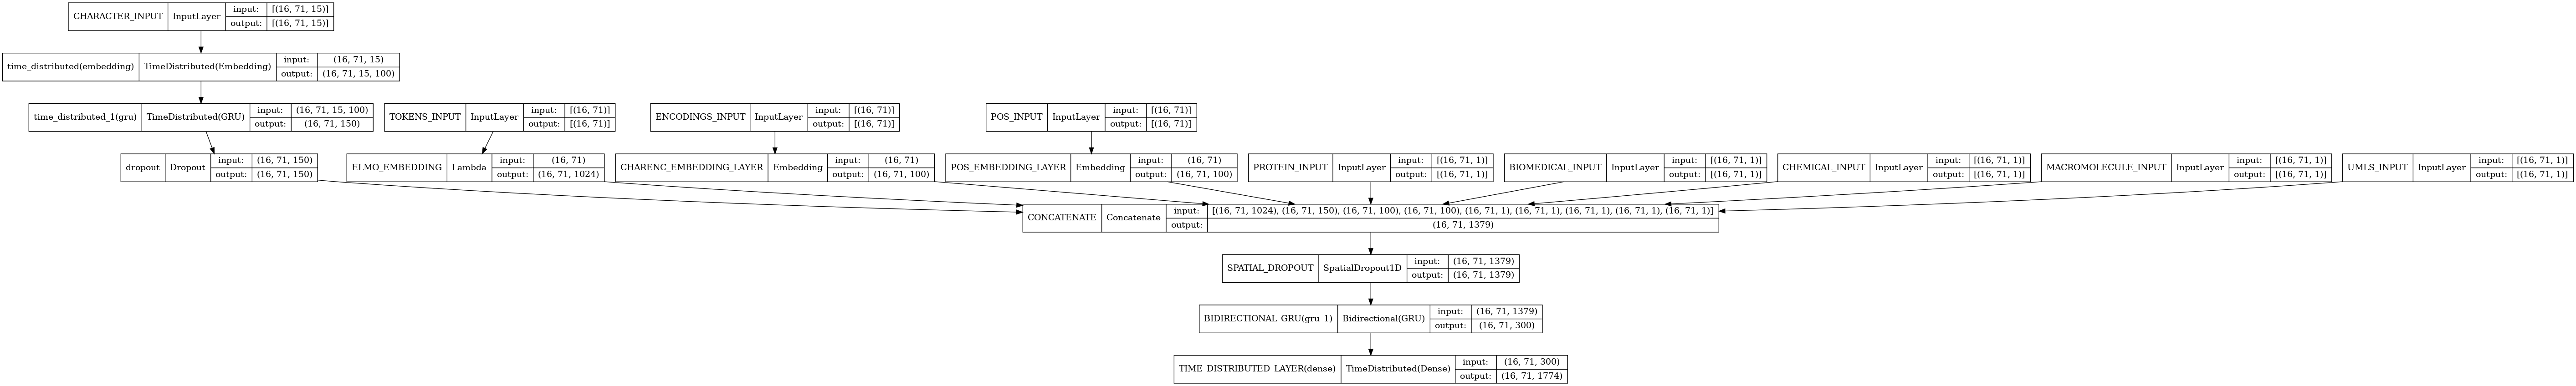

In [15]:
model = Model(inputs, output, name=CONFIG.get("PROJECT_NAME") + "_" + CONFIG.get("RUN"))
model.compile(optimizer=OPTIMIZER, loss=globals()[CONFIG.get("LOSS_FUNCTION")](), metrics=['accuracy'])
print(model.summary())
model_arch = tf.keras.utils.plot_model(model, show_shapes=True, to_file=join(MODEL_OUTPUT_DIR, "model.png"))
display(model_arch)

## Define Callbacks and class weights (for imbalanced dataset)

In [16]:
if CONFIG.get("OPTIMIZED_CLASS_WEIGHT"):
    tags = list(j for i in train_data+test_data for j in i['iob_tags']) + [CONFIG.get("PAD_CHAR")]
    unique_tags = set(tags)
    total_count = {}
    for i in unique_tags:
        total_count.update({i: tags.count(i)})

    total = len(tags)
    class_weights = {}
    for k, v in total_count.items():
        # class_weights.update({tag2idx[k]: np.log((1 / v) * (total / 2.0))})
        class_weights.update({tag2idx[k]: 1 - (v/total)})
else:
    class_weights = None

if CONFIG.get("REDUCE_LR_ON_PLATEAU"):
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=4,
        verbose=1,
        min_lr=0.00000003,
        mode='auto',
        cooldown=0,
        min_delta=0.0001
    )
    CALLBACKS = [reduce_lr]
else:
    CALLBACKS = []

if CONFIG.get("EARLY_STOPPING"):
    CALLBACKS += [EarlyStopping(
        monitor='val_loss',
        min_delta=0.0001,
        patience=10,
        verbose=1,
        mode='min',
        baseline=None,
        restore_best_weights=False
    )]

## Train model

Check if the prediction file is already in the directory (model.name) and if so, do not train the model. Use the prediction data to calculate score or other computation.
If the model needs to be trained anyhow, remove the model.name directory from `data\model_output\predictions` directory.

In [17]:
def file_exists(directory: str):
    # Checks to see if prediction is already saved for a given model name
    if os.path.exists(directory):
        checkpoint = join(directory, "checkpoint")
        if os.path.exists(checkpoint):
            splits = json.load(open(checkpoint, "r")).get('split', None)
            if splits:
                for i in range(splits):
                    if not os.path.exists(join(directory, "prediction_{0}.npy".format(str(i+1).zfill(5)))):
                        return False
                return True
    return False

In [18]:
if not file_exists(join(MODEL_OUTPUT_DIR, "predictions", model.name)):
    history = model.fit(
        X_train, Y_train, 
        batch_size=CONFIG.get("BATCH_SIZE"),
        epochs=CONFIG.get("EPOCHS"),
        validation_data=(X_test, Y_test),
        class_weight = class_weights,
        verbose=1,
        callbacks=CALLBACKS,
    )

## Make and save predictions

In [19]:
prediction_path = join(MODEL_OUTPUT_DIR, "predictions", model.name)
if not file_exists(prediction_path):
    batch_size = int(np.ceil(len(X_test[0])/CONFIG.get("OUTPUT_PARTS")))
    if not os.path.exists(prediction_path): os.makedirs(prediction_path)
    with open(join(prediction_path, "checkpoint"), "w") as f:
        json.dump({"split": CONFIG.get("OUTPUT_PARTS")}, f)
    for i in range(CONFIG.get("OUTPUT_PARTS")):
#         temp = predicted[i*batch_size:(i+1)*batch_size]
        temp = [j[i*batch_size:(i+1)*batch_size] for j in X_test]
        with open(join(prediction_path, "prediction_{0}.npy".format(str(i+1).zfill(5))), "wb") as f:
            np.save(f, model.predict(temp))
#             np.save(f, temp)
#     del predicted
    del temp

## Evaluate model performance

The performance of this experiment is evaluated using a modified F1 score and semantic similarity score. The model is tasked with predicting non-annotations (indicated by an $\texttt{`O'}$ tag) or annotations (indicated by a $\texttt{`GO'}$ tag). Since the majority of tags in the training corpus are non-annotations, the model predicts them with great accuracy. In order to avoid biasing the F1 score, we omit accurate predictions of $\texttt{`O'}$ tags from the calculation to report a relatively conservative F1 score.

In [21]:
report_summary = {}
ground_truth, prediction, prediction_n, word = [], [], [], []
top_n_scores = [1, 2, 3, 5] # To evaluate model using top_n accuracy metrics 
for top_n in top_n_scores:
    pos = 0
    pd_data_list = []
    for part in range(CONFIG.get("OUTPUT_PARTS")):
        ground_truth, prediction, prediction_n, word = [], [], [], []
        predicted = np.load(join(prediction_path, "prediction_{0}.npy".format(str(part+1).zfill(5))))
        for i in range(predicted.shape[0]):
            word.append(X_test[0][pos+i])
            if Y_train.ndim == 2:
                true_vec = Y_test[pos+i]
            else:
                true_vec = np.argmax(Y_test[pos+i], axis=-1)
            ground_truth.append(true_vec)
            pred_vec = np.argsort(predicted[i]*-1, axis=-1)[:,:top_n]
            temp = np.array([x if x in y else y[0] for x, y in zip(true_vec, pred_vec)], dtype='int32')
            prediction.append(temp)
            prediction_n.append(pred_vec.tolist())
        pos += predicted.shape[0]
        t = [list(map(idx2tag.get, i)) for i in ground_truth]
        sent_len = [i.index("EOS")+1 if "EOS" in i else CONFIG.get("MAX_WORD_LEN") + 1 for i in t]
        t = [i[:sent_len[idx]] for idx, i in enumerate(t)]
        wd = [i[:sent_len[idx]] for idx, i in enumerate(word)]
        p = [list(map(idx2tag.get, i[:sent_len[idx]])) for idx, i in enumerate(prediction)]
        p_n = [[list(map(idx2tag.get, j)) for j in i[:sent_len[idx]]] for idx, i in enumerate(prediction_n)]
        pd_data = pd.DataFrame({
            'Ground_Truth': list(chain.from_iterable(t)),
            'Prediction': list(chain.from_iterable(p)),
            'Prediction_n': list(chain.from_iterable(p_n)),
            'Word': list(chain.from_iterable(wd)),
        })
        df1 = pd_data[(pd_data['Word'] != CONFIG.get("PAD_CHAR")) & (pd_data['Ground_Truth'] != "EOS")].copy()
        df1 = df1[(df1['Prediction'] != 'O') & (df1['Ground_Truth'] != 'O') | 
                (df1['Prediction'] == 'O') & (df1['Ground_Truth'] != 'O') |
                (df1['Prediction'] != 'O') & (df1['Ground_Truth'] == 'O')]
        df2 = df1.copy()
        df2['GO_Prediction'] = df2['Prediction'].apply(lambda x: x[2:] if "GO:" in x else x)
        df2['GO_Ground_Truth'] = df2['Ground_Truth'].apply(lambda x: x[2:] if "GO:" in x else x)
        pd_data_list.append(df2)
    all_data = pd.concat(pd_data_list)
    report = classification_report(all_data['GO_Ground_Truth'], all_data['GO_Prediction'], zero_division=False)
    report_summary.update({"top_{0}".format(top_n): dict((k, v) for k, v in 
                                                             zip(report.split("\n")[0].split(), report.split("\n")[-2].split()[2:]))})
    if top_n == 1:
        go_category = json.load(open(join(DATA_DIR, "GO_Category/go_category.json"), "r"))
        for k, v in go_category.items():
            temp = all_data[(all_data['GO_Prediction'].isin(v)) | (all_data['GO_Ground_Truth'].isin(v))]
            score = {"F1_" + k: classification_report(temp['GO_Ground_Truth'], temp['GO_Prediction'], zero_division=False).splitlines()[-1].split()[-2]}
            report_summary['top_1'].update(score)
        sem_score = {"MEAN_SEMANTIC_SIMILARITY": np.round(all_data[['GO_Prediction','GO_Ground_Truth']].apply(
            lambda x: getsimj(x[0].replace("GO:", "GO_"), x[1].replace("GO:", "GO_")), axis=1).mean(), 6)}
        report_summary.update(sem_score)
report_summary = dict(sorted(((k, v) for k, v in report_summary.items()), key=lambda x: x[0]))
for k, v in report_summary.items():
    print(k, ":", v)
with open(join(prediction_path, "report.txt"), "w+") as f:
    f.write(report)
with open(join(prediction_path, "report_summary.json"), "w+") as f:
    json.dump(report_summary, f, indent=4, sort_keys=True)

MEAN_SEMANTIC_SIMILARITY : 0.838903
top_1 : {'precision': '0.85', 'recall': '0.83', 'f1-score': '0.83', 'support': '5228', 'F1_GO_BP': '0.82', 'F1_GO_MF': '0.97', 'F1_GO_CC': '0.83'}
top_2 : {'precision': '0.91', 'recall': '0.90', 'f1-score': '0.90', 'support': '5149'}
top_3 : {'precision': '0.91', 'recall': '0.91', 'f1-score': '0.91', 'support': '5141'}
top_5 : {'precision': '0.92', 'recall': '0.92', 'f1-score': '0.91', 'support': '5135'}
